In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xa
from pprint import pprint

fdir = "/home/jungyoung/Project_win/hh_neuralnet/"

import sys
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal

import hhclustering as hc
import utils 
import scipy

from importlib import reload
reload(utils)

from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from numba import njit

# Show the clustering result on the 2D plane

In [145]:
# Load dataset
tag = ""
feature_dims = (15, 15, 3, 16)

postdata = xa.open_dataarray("../three_pop_mpi/simulation_data/post_inv.nc")

with open("./data/align_data_sub%s.pkl"%(tag), 'rb') as fp:
    align_data_sub = pkl.load(fp)
    
data = align_data_sub["data"].copy()
echelon = np.array([c["rank"] for c in align_data_sub["col_names"]])

clusters = xa.load_dataset("./data/cluster_id_tot.nc")
cluster_id = clusters.cluster_id.data.flatten().copy()

# min-max normalize
svals = clusters.sval.data.flatten().copy()
svals = (svals - svals.min())/(svals.max() - svals.min())

In [ ]:
keys = ({"key": "ac2p_large", "pop": "F", "type": "mean"},
        {"key": "ac2p_large", "pop": "F", "type": "var"},
        {"key": "ac2p_large", "pop": "S", "type": "mean"},
        {"key": "ac2p_large", "pop": "S", "type": "var"},
        {"key": "fp_large", "pop": "F", "type": "mean"},
        {"key": "fp_large", "pop": "F", "type": "var"},
        {"key": "fp_large", "pop": "S", "type": "mean"},
        {"key": "fp_large", "pop": "S", "type": "var"},
        {"key": "ac2p_1st", "pop": "F", "type": "mean"},
        {"key": "ac2p_1st", "pop": "F", "type": "var"},
        {"key": "ac2p_1st", "pop": "S", "type": "mean"},
        {"key": "ac2p_1st", "pop": "S", "type": "var"},
        {"key": "fp_1st", "pop": "F", "type": "mean"},
        {"key": "fp_1st", "pop": "F", "type": "var"},
        {"key": "fp_1st", "pop": "S", "type": "mean"},
        {"key": "fp_1st", "pop": "S", "type": "var"},
        {"key": "cc1p", "pop": "F", "type": "mean"},
        {"key": "cc1p", "pop": "F", "type": "var"},
        {"key": "tlag_cc", "pop": "F", "type": "mean"},
        {"key": "tlag_cc", "pop": "F", "type": "std"},
        {"key": "leading_ratio", "pop": "F", "type": "mean"},
        

In [170]:
postdata.coords["key"]

<xarray.DataArray 'key' (key: 16)>
array(['chi', 'cv', 'frs_m', 'ac2p_large', 'fp_large', 'ac2p_1st', 'fp_1st',
       'pwr_large_ft', 'fp_large_ft', 'pwr_1st_ft', 'fp_1st_ft', 'cc1p',
       'tlag_cc', 'leading_ratio', 'leading_ratio(abs)', 'dphi'], dtype=object)
Coordinates:
  * key      (key) object 'chi' 'cv' 'frs_m' ... 'leading_ratio(abs)' 'dphi'

In [169]:
align_data_sub["row_names"]

['ac2p_large(F)',
 'ac2p_large(F)_std',
 'ac2p_large(S)',
 'ac2p_large(S)_std',
 'tlag_large(F)',
 'tlag_large(F)_std',
 'tlag_large(S)',
 'tlag_large(S)_std',
 'ac2p_1st(F)',
 'ac2p_1st(F)_std',
 'ac2p_1st(S)',
 'ac2p_1st(S)_std',
 'tlag_1st(F)',
 'tlag_1st(F)_std',
 'tlag_1st(S)',
 'tlag_1st(S)_std',
 'cc1p(F)',
 'cc1p(F)_std',
 'tlag_cc(F)',
 'tlag_cc(F)_std',
 'leading_ratio(F)',
 'leading_ratio(abs)(F)',
 'dphi(F)',
 'dphi(F)_std']

In [173]:
with open("./data/kmeans_cluster.pkl", "rb") as fp:
    kk = pkl.load(fp)

/home/jungyoung/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [174]:
kk.keys()

dict_keys(['km_obj_set', 's_scores', 's_vals', 'km_scores', 'num_clusters'])

In [165]:
align_data_sub.keys()

dict_keys(['data', 'pop_types', 'row_names', 'row_labels', 'col_names'])

In [152]:
align_data_sub.keys()

dict_keys(['data', 'pop_types', 'row_names', 'row_labels', 'col_names'])

In [150]:
postdata.coords["key"]

<xarray.DataArray 'key' (key: 16)>
array(['chi', 'cv', 'frs_m', 'ac2p_large', 'fp_large', 'ac2p_1st', 'fp_1st',
       'pwr_large_ft', 'fp_large_ft', 'pwr_1st_ft', 'fp_1st_ft', 'cc1p',
       'tlag_cc', 'leading_ratio', 'leading_ratio(abs)', 'dphi'], dtype=object)
Coordinates:
  * key      (key) object 'chi' 'cv' 'frs_m' ... 'leading_ratio(abs)' 'dphi'

In [136]:
import umap

umap_obj = umap.UMAP(random_state=42, n_neighbors=100, n_components=2, metric="euclidean", min_dist=0.8)
umap_obj.fit(data.T)

/home/jungyoung/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.8, n_jobs=1, n_neighbors=100, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [137]:
data_umap = umap_obj.transform(data.T)

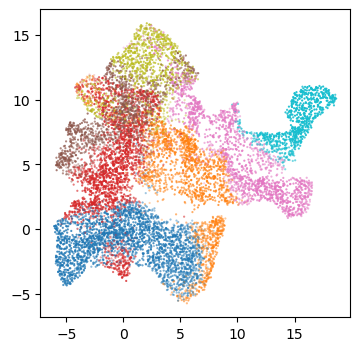

In [141]:
plt.figure(figsize=(4, 4))
plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, c=cluster_id, alpha=svals, edgecolor="none", cmap="tab10",
           marker=".")
# plt.axis("equal")
# plt.ylim([-12, 23])
# plt.xlim([-10, 23])
plt.show()

In [144]:
data.shape

(24, 10800)

In [ ]:
fig, axs = plt.subplots(3, 7, figsize=(10, 3))
for n in range(21

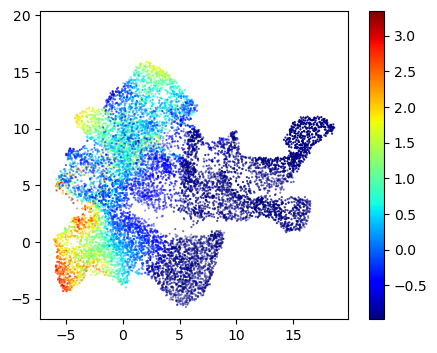

In [143]:
plt.figure(figsize=(5, 4))
plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, c=data[-1], alpha=svals, edgecolor="none", cmap="jet",
           marker=".")
plt.colorbar()
plt.axis("square")
plt.show()

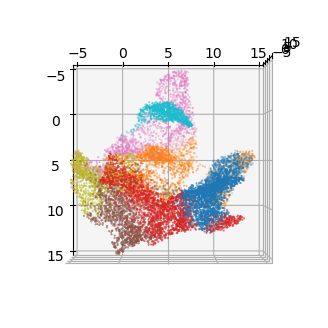

In [68]:
# from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(data_umap[:, 0], data_umap[:, 1], data_umap[:, 2], marker='.', s=1, c=cluster_id, cmap="tab10")
plt.xlim([-5, 15])
plt.ylim([-5, 15])
ax.set_zlim([-5, 15])
ax.view_init(90, 0)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Generate data
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Display the plot
plt.show()

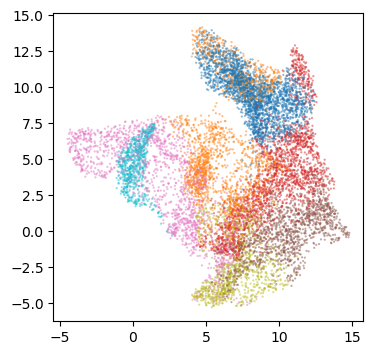

In [53]:
plt.figure(figsize=(4, 4))
plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, c=cluster_id, alpha=0.5, edgecolor="none", cmap="tab10",
           marker=".")
plt.show()

In [42]:
from sklearn.manifold import TSNE

In [45]:
tsne_obj = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_obj.fit_transform(data.T)

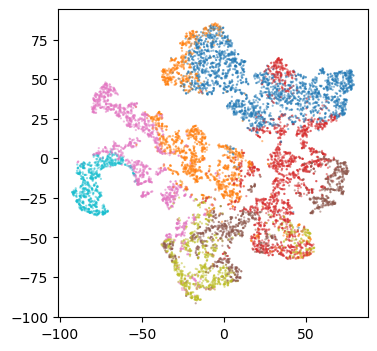

In [46]:
plt.figure(figsize=(4, 4))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=10, c=cluster_id, alpha=0.5, edgecolor="none", cmap="tab10",
           marker=".")
plt.show()

In [47]:
with open('../information_routing/data/te_2d_mua/te_100.pkl', 'rb') as fp:
    te_data = pkl.load(fp)

In [ ]:
python computeTE4.py --cid=1 --wid=2 --ntrue=100 --nsurr=1000 --method="2d" --target="mua"

In [3]:
def get_base_idx(ne):
    return 16*ne + np.arange(16)
    

# summary_obj = hhtools.SummaryLoader("../three_pop_mpi/simulation_data/data", load_only_control=True)
# cid_dataset = xa.load_dataset("./data/cluster_id_update_sub.nc")

tag = "_mslow"
summary_obj = hhtools.SummaryLoader("../mono_pop_mpi//simulation_data/data_slow", load_only_control=True)
cid_dataset = xa.load_dataset("./data/cluster_id_sub%s.nc"%(tag))

cid_flat = cid_dataset.cluster_id.data.flatten()

with open("./data/align_data_sub%s.pkl"%(tag), 'rb') as fp:
    align_data = pkl.load(fp)
echelon = np.array([c["rank"] for c in align_data["col_names"]])
data_partial = align_data["data"][:-2, :]
lb_partial = align_data["row_labels"][:-2]
num_lb = len(lb_partial)

# Find representative point

In [14]:
cid_dataset.id_set.astype(int)

array([1, 2, 3, 4, 5, 6, 7])

In [16]:
nbest = 50
repr_locs = dict(key_names=("alpha", "beta", "echelon", "w"),
                 nbest=nbest,
                 loc=[[] for i in range(10)])

cid_set = cid_dataset.id_set.astype(int)
for target_id in cid_set:
    idx = np.array(np.where(cid_dataset.cluster_id == target_id))
    sval_sub = np.array([cid_dataset.sval.data[idx[0][i], idx[1][i], idx[2][i], idx[3][i]] for i in range(len(idx[0]))])
    w = (sval_sub - np.min(sval_sub)) / (np.max(sval_sub) - np.min(sval_sub))

    w_sort = np.sort(w)[::-1]
    idx_sort = idx[:, np.argsort(w)[::-1]]
    
    # nbest = 300
    # nbest = 50
    nbest = int(0.1 * len(sval_sub))
    wsum = 0
    idx_center = np.zeros(4)
    for n in range(nbest):
        idx_center += idx_sort[:, n] * w_sort[n]
    idx_center = np.round(idx_center / nbest)

    repr_locs["loc"][target_id] = idx_center

with open("./data/cluster_repr_points%s.pkl"%(tag), "wb") as fp:
    pkl.dump(repr_locs, fp)

In [ ]:
repr_locs["loc"]

In [18]:
for i in cid_set:
    loc = np.array(repr_locs["loc"][i], dtype=int)
    print("%.2f, %.2f, %.1f, %f"%(summary_obj.controls["alpha_set"][loc[0]], summary_obj.controls["beta_set"][loc[1]], summary_obj.controls["rank_set"][loc[2]], summary_obj.controls["w_set"][loc[3]]))

0.29, 0.29, 0.0, 0.500000
1.43, 0.71, 0.0, 0.500000
1.43, 0.50, 0.5, 0.250000
1.71, 0.21, 0.5, 0.250000
0.43, 0.50, 0.5, 0.500000
0.71, 0.36, 1.0, 0.750000
1.57, 0.86, 1.0, 0.750000


# Show representative dynamics

In [ ]:
tp_labels = ("Fast", "Slow")

for target_id in range(1, 10): # target_id = 8

    idx = np.where(cid_dataset.cluster_id == target_id)
    sval_sub = np.array([cid_dataset.sval.data[idx[0][i], idx[1][i], idx[2][i], idx[3][i]] for i in range(len(idx[0]))])
    
    nmax = np.argmax(sval_sub)
    idx_max = [n[nmax] for n in idx]
    
    detail_data = summary_obj.load_detail(*repr_locs["loc"][target_id], 0)
    idx_max_flat = int(summary_obj.get_id(*repr_locs["loc"][target_id], 0) // 9)
    
    num_echelon, _ = np.histogram(echelon[cid_flat == target_id], [0, 1, 2, 3])
    num_echelon_dom = np.argmax(num_echelon)
    data_base = data_partial[:, get_base_idx(num_echelon_dom)].mean(axis=1)
    
    w = (sval_sub - np.min(sval_sub)) / (np.max(sval_sub) - np.min(sval_sub))
    data_partial_mean = np.average(data_partial[:, cid_flat==target_id] * w[None, :], axis=1)
    
    plt.figure(figsize=(10, 3))
    
    plt.axes(position=(0.1, 0.3, 0.5, 0.6))
    plt.plot(data_partial[:, cid_flat==target_id]-data_base[:, None], 'k', alpha=0.01)
    plt.plot(data_partial[:, idx_max_flat]-data_base, 'r')
    # plt.plot(data_partial[:, cid_flat==target_id].mean(axis=1)-data_base, 'r')
    # plt.plot(data_partial_mean-data_base, "r")
    plt.plot([-0.5, num_lb-0.5], [0, 0], 'k--', zorder=-1)
    plt.xticks(np.arange(num_lb), lb_partial, rotation=60, fontsize=10)
    plt.ylim([-5, 5])
    plt.xlim([-0.5, num_lb-0.5])
    plt.ylabel(r"$Z - Z_{\alpha=\beta=0}$", fontsize=14)
    
    ax_f = plt.axes(position=(0.68, 0.52, 0.22, 0.38))
    ax_s = plt.axes(position=(0.68, 0.05, 0.22, 0.38))
    for n, ax in enumerate([ax_f, ax_s]):
        plt.axes(ax)
        psd_t, fpsd, tpsd = hhsignal.get_stfft(detail_data["vlfp"][n+1], detail_data["ts"], fs=2000, mbin_t=0.1, wbin_t=0.5, frange=(5, 100))
        hhtools.imshow_xy(psd_t, x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic", vmin=0.0, vmax=None)
        plt.xlim([0.5, 4.5])
        plt.xticks([])
        plt.ylabel("Frequency (Hz)", fontsize=10)        
        ob = hhtools.AnchoredHScaleBar(ax=ax, size=1, label="1 s", loc="lower left", frameon=False,
                            pad=0.08, sep=2, linecolor="w", fontcolor="w",
                            fontsize=12, fontstyle="italic")
        ax.add_artist(ob)
        plt.text(3.2, 80, tp_labels[n], color="w", fontsize=14, fontstyle="italic", fontweight="bold")
    
    # plt.show()
    plt.savefig("./figs/cluster_features/cid%d.png"%(target_id), bbox_inches="tight")

# Fequency change in each cluster

In [271]:
def _fft(detail):
    idt = detail["ts"] >= 0.5
    vlfp = detail["vlfp"][nt][idt]
    ts = detail["ts"][idt]
    fs = np.round(1/(ts[1] - ts[0]))

    # psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, ts, fs, mbin_t=0.1, wbin_t=1, frange=(3, 120))
    psd, fpsd = hhsignal.get_fft(vlfp, fs, nbin_t=2, frange=(3, 200))
    return psd, fpsd


psd_set, psd_base_set = [], []
for cid in range(1, 10):
    psd_tot = [0, 0, 0]
    for i in range(9):
        detail = summary_obj.load_detail(*repr_locs["loc"][cid], i)
        for nt in range(3):    
            psd, fpsd = _fft(detail)
            psd_tot[nt] += psd/9
    psd_set.append(psd_tot)

    # base
    psd_base = [0, 0, 0]    
    nechelon = repr_locs["loc"][cid][2]
    
    for i in range(9):
        detail_base = sobj_base.load_detail(0, 0, nechelon, 0, i)
        for nt in range(3):
            psd_b, fpsd_b = _fft(detail_base)
            psd_base[nt] += psd_b/9
    psd_base_set.append(psd_base)

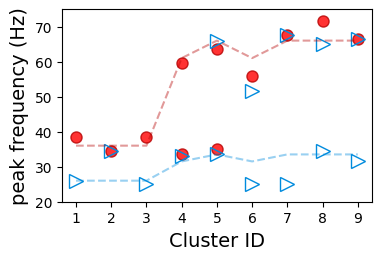

In [273]:
from scipy.signal import savgol_filter

plt.figure(figsize=(4, 2.5))

cset = ["k", "#b50202", "#008bdd"]
markers = ["", "o", ">"]

# fpeaks = [[] for _ in range(8)]
fpeaks_b = [[], [], []]

for nc in range(9):
    for nt in range(1, 3):
        yhat = savgol_filter(psd_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat, prominence=0.01, mode=0)
        
        # print("Cluster %d"%(nc+1))
        for n in npeaks:
            if nt == 1:
                plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt], markerfacecolor=[1, 0, 0, 0.8], markersize=8)
            if nt == 2:
                plt.plot(nc+1, fpsd[n], markers[nt], color=cset[nt], markerfacecolor="none", markersize=10)
            # print("%.3f"%(fpsd[n]))
            
        yhat_b = savgol_filter(psd_base_set[nc][nt], 21, 1)
        npeaks = hhsignal.detect_peak(yhat_b, prominence=0.02, mode=0)
        
        fpeaks_b[nt].append(fpsd[npeaks[0]])

fpeaks_b[1][-3] = fpeaks_b[1][-1]
fpeaks_b[2][-3] = fpeaks_b[2][-1]
        
plt.plot(np.arange(9)+1, fpeaks_b[1], '--', c=cset[1], alpha=0.4)
plt.plot(np.arange(9)+1, fpeaks_b[2], '--', c=cset[2], alpha=0.4)

plt.xticks(np.arange(1, 10))
plt.ylim([20, 75])

plt.xlabel("Cluster ID", fontsize=14)
plt.ylabel("peak frequency (Hz)", fontsize=14)

plt.show()